# Week 7 Multi-Resolution Splines

### Date: 23 Nov 2023

Today we will be looking at blending images using multi-resolution splines. We will first start off by building a Gaussian pyramid, followed by a Laplacian Pyramid. We will then look at how to combine two Laplacian Pyramids to blend two images together to replicate the classic orange and apple image shown further down.



In [15]:
import numpy as np
import cv2
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
plt.style.use('default')
# to visualize the plots within the notebook
%matplotlib inline

## Load images

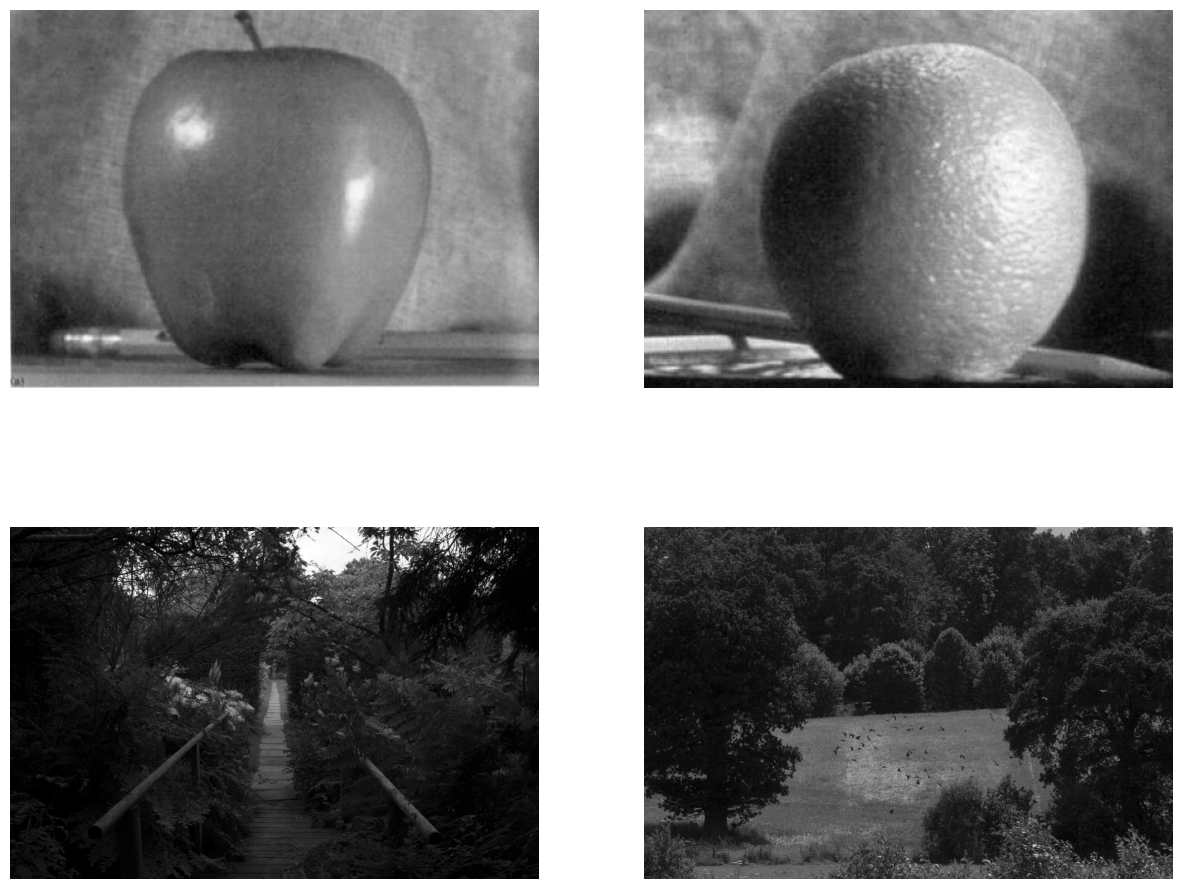

In [23]:
img1 = cv2.imread('../images/apple1.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY).astype(np.float32)
img2 = cv2.imread('../images/orange1.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY).astype(np.float32)
img3 = cv2.imread('../images/IMG_4825.jpg')
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY).astype(np.float32)
img4 = cv2.imread('../images/IMG_5024.jpg')
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2GRAY).astype(np.float32)
fig, axes = plt.subplots(2,2, figsize=(15,12))
axes[0,0].imshow(img1, "gray")
axes[0,0].set_axis_off()
axes[0,1].imshow(img2, "gray")
axes[0,1].set_axis_off()
axes[1,0].imshow(img3, "gray")
axes[1,0].set_axis_off()
axes[1,1].imshow(img4, "gray")
axes[1,1].set_axis_off()
plt.show()

## Task 1: Gaussian Pyramid


To build a Gaussian Pyramid	we will first need to create a method that will apply 2D convolution with a Gaussian kernel, which is defined as:

$$H_\sigma = \frac{1}{2\pi\sigma^2}e^{-\frac{x^2+y^2}{2\sigma^2}}$$

A Gaussian pyramid is then be built by convolving and down-sampling, giving us a sequence of low-pass filtered images $G_0, G_1, G_2, ..., G_n$:

<img src="../images/W7-Gaussian.png" alt="Gaussian Pyramid" width="500"/>

**Hint: You can use the functions you wrote in last week's lab for creating Gaussian kernel and applying 2D convolution. For up/down sampling, you can use `cv2.resize()`**

In [17]:
"""
Utility functions here, you can use code from the last week. FFT implementation is reccomended as it is faster.
"""
from scipy.signal import convolve2d


def get_gaussian_kernel(h, w, sigma):
    ax = np.linspace(-(w - 1) / 2., (w - 1) / 2., w)
    ay = np.linspace(-(h - 1) / 2., (h - 1) / 2., h)
    xx, yy = np.meshgrid(ax, ay)
    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sigma))
    return kernel / np.sum(kernel)

def apply_filter(src_img, kernel):
    return convolve2d(src_img, kernel, mode='same', boundary='fill', fillvalue=0)


def apply_gaussian_filter(src_img, k=5, sigma=1.0):
    kernel = get_gaussian_kernel(k, k, sigma)
    return apply_filter(src_img, kernel)


"""
Implement your own PyrDown() and PyrUp() functions
"""
def myPyrDown(img, dstsize, k=5, sigma=1.0):
    """
    """
    filtered_img = apply_gaussian_filter(img, k, sigma)
    return cv2.resize(filtered_img, dsize=dstsize, interpolation=cv2.INTER_LINEAR)

def myPyrUp(img, dstsize, k=5, sigma=1.0):
    """
    """
    upsampled_img = cv2.resize(img, dsize=dstsize, interpolation=cv2.INTER_LINEAR)
    return apply_gaussian_filter(upsampled_img, k, sigma)

### Construct and visualize Gaussian Pyramids

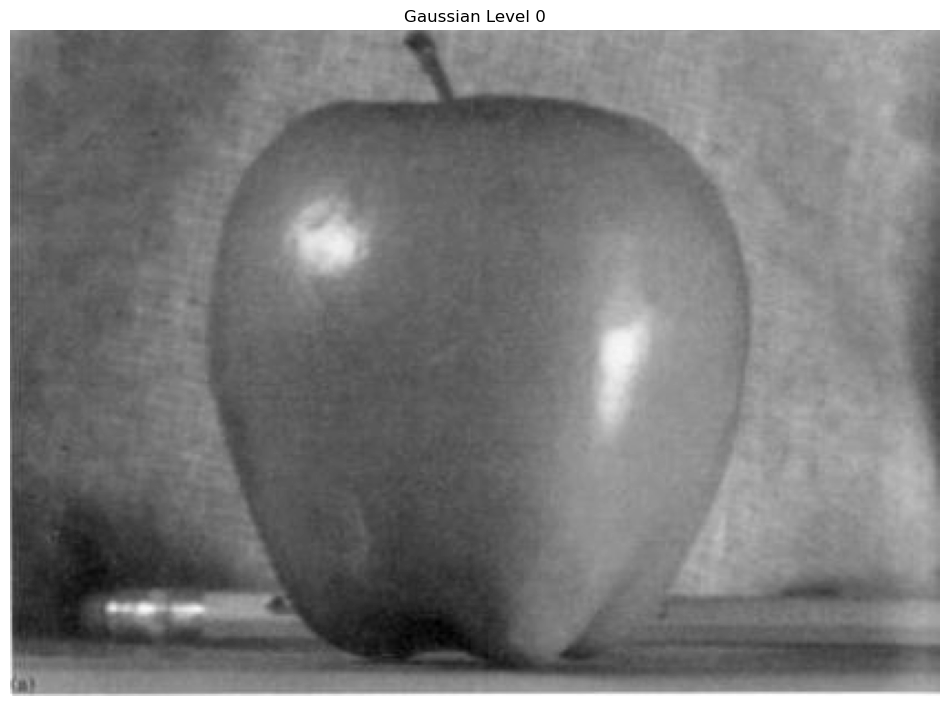

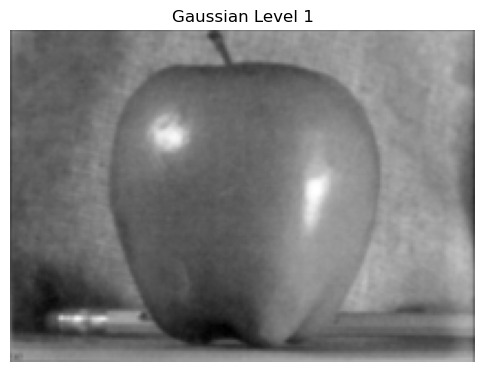

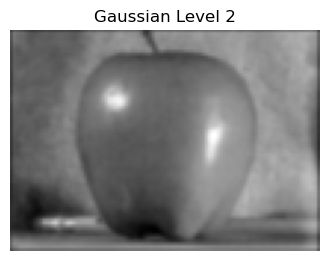

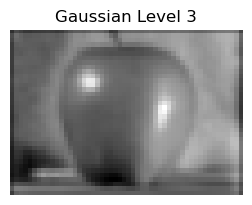

In [18]:
def make_gaussian_pyramids(img, max_level=3, k=5, sigma=1.0):
    gp = {0: img}
    """
    """
    for level in range(1, max_level + 1):
        # Get the current image
        current_img = gp[level - 1]

        # Downsample the current image
        # Calculate the new size for downsampling
        dstsize = (current_img.shape[1] // 2, current_img.shape[0] // 2)
        
        # Apply Gaussian filter and downsample
        downsampled_img = myPyrDown(current_img, dstsize, k, sigma)
        
        # Store in the pyramid
        gp[level] = downsampled_img
    return gp


# Visualize Gaussian Pyramids
def visualize_gaussian_pyramids(gp, fsize=12):
    num_levels = len(gp.keys())
    for l in range(num_levels):
        plt.figure(figsize=(fsize / (l + 1), fsize / (l + 1)))
        plt.imshow(gp[l], "gray")
        plt.title("Gaussian Level {}".format(l))
        plt.axis('off')
    plt.show()

gp1 = make_gaussian_pyramids(img1)
visualize_gaussian_pyramids(gp1)

## Task 2: Laplacian Pyramid

Next it’s time to build a (band-pass) Laplacian pyramid. This can be built using your Gaussian pyramid, each level will be	computed by	taking the difference from one level to the next, therefore:

$L_i = G_i - \text{EXPAND}(G_{i+1})$

Resulting in $L_0, L_1, L_2, ..., L_n$, where EXPAND() represents upsampling and then convolving with the same kernel you used before.

![Laplacian Pyramid](../images/W7-Laplacian.png)

### Construct and visualize Laplacian Pyramids

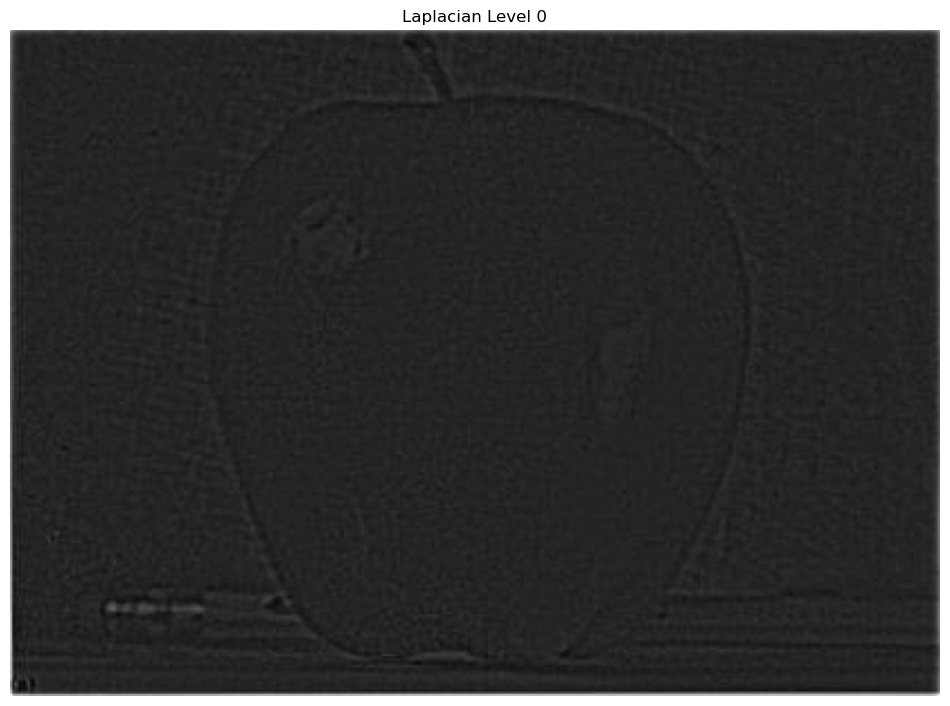

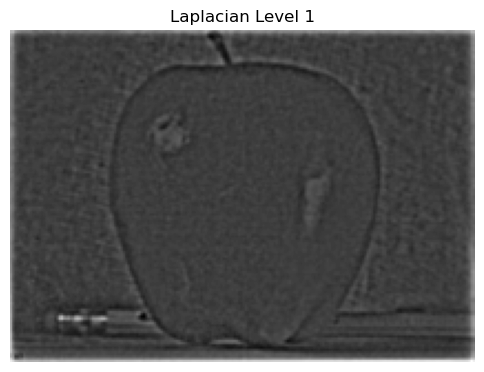

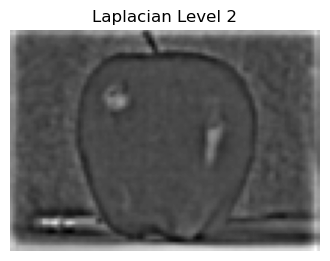

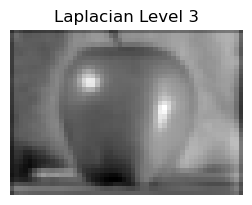

In [19]:
def make_laplacian_pyramids(gp):
    lp = {}
    """
    """
    num_levels = len(gp)

    # For each level in the Gaussian pyramid, except the last one
    for level in range(num_levels - 1):
        # Get the current level image
        gauss_current = gp[level]

        # Upsample the next level image
        gauss_next = gp[level + 1]
        dstsize = (gauss_next.shape[1] * 2, gauss_next.shape[0] * 2)
        
        # Apply Gaussian filter and upsample and 变换成大小相同的图
        upsampled = myPyrUp(gauss_next, dstsize)
        upsampled = cv2.resize(upsampled, (gauss_current.shape[1], gauss_current.shape[0]))
        upsampled = upsampled.astype(gauss_current.dtype)

        # Calculate the Laplacian (difference between the current level and the upsampled image)
        # 计算当前层的图像与上采样后图像的差异，这个差异即为拉普拉斯层。
        laplacian = cv2.subtract(gauss_current, upsampled)
        lp[level] = laplacian

    # The highest level of the Laplacian pyramid is the same as the Gaussian pyramid
    lp[num_levels - 1] = gp[num_levels - 1]
    return lp

def visualize_laplacian_pyramids(lp, fsize=12):
    num_levels = len(lp.keys())
    for l in range(num_levels):
        plt.figure(figsize=(fsize / (l + 1), fsize / (l + 1)))
        plt.imshow(lp[l], "gray")
        plt.title("Laplacian Level {}".format(l))
        plt.axis('off')
    plt.show()

lp1 = make_laplacian_pyramids(gp1)
visualize_laplacian_pyramids(lp1)

## Task 3: Image Blending with Multi-Resolution Spline

Once we have the methods that will create out Gaussian and Laplacian pyramids, we can use these to blend out images together using the following algorithm:

1) First compute the Laplacian pyramids $LA$ and $LB$ for images A and B

2) We then need to create a mask that will be used to blend out images. For this you can simply zeroing out the right half of the image.

3) Once we have a mask, we want to create a Gaussian pyramid of the mask, $GR$.

4) We now need to compute the Laplacian pyramid LS that is a combination of $LA$ and $LB$, computed by

$$LS_i = GR_iLA_i + (1-GR_i)LB_i$$

5) The pyramid LS now needs to be expanded, this is done by simply upscaling and adding each level from tom to bottom.

In [31]:
"""
Implement your functions here
"""
# Blend two Laplace Pyramids with given Gaussian Pyramids of the mask
def blend_laplacians(gp_mask, lp1, lp2):
    """
    """
    blended_lp = {}
    for level in range(len(gp_mask)):
        mask = gp_mask[level]
        blended_lp[level] = mask * lp1[level] + (1 - mask) * lp2[level]
    return blended_lp

# Construct image with given Laplace Pyramids
def laplacian_collapse(lp):
    """
    """
    reconstructed_image = lp[len(lp) - 1]  # Start from the top level
    for level in range(len(lp) - 2, -1, -1):  # Go down the pyramid
        # Calculate the destination size for PyrUp
        dstsize = (lp[level].shape[1], lp[level].shape[0])

        # Use custom PyrUp function
        upsampled = myPyrUp(reconstructed_image, dstsize)

        # Add the current Laplacian level
        reconstructed_image = upsampled + lp[level]

    return reconstructed_image

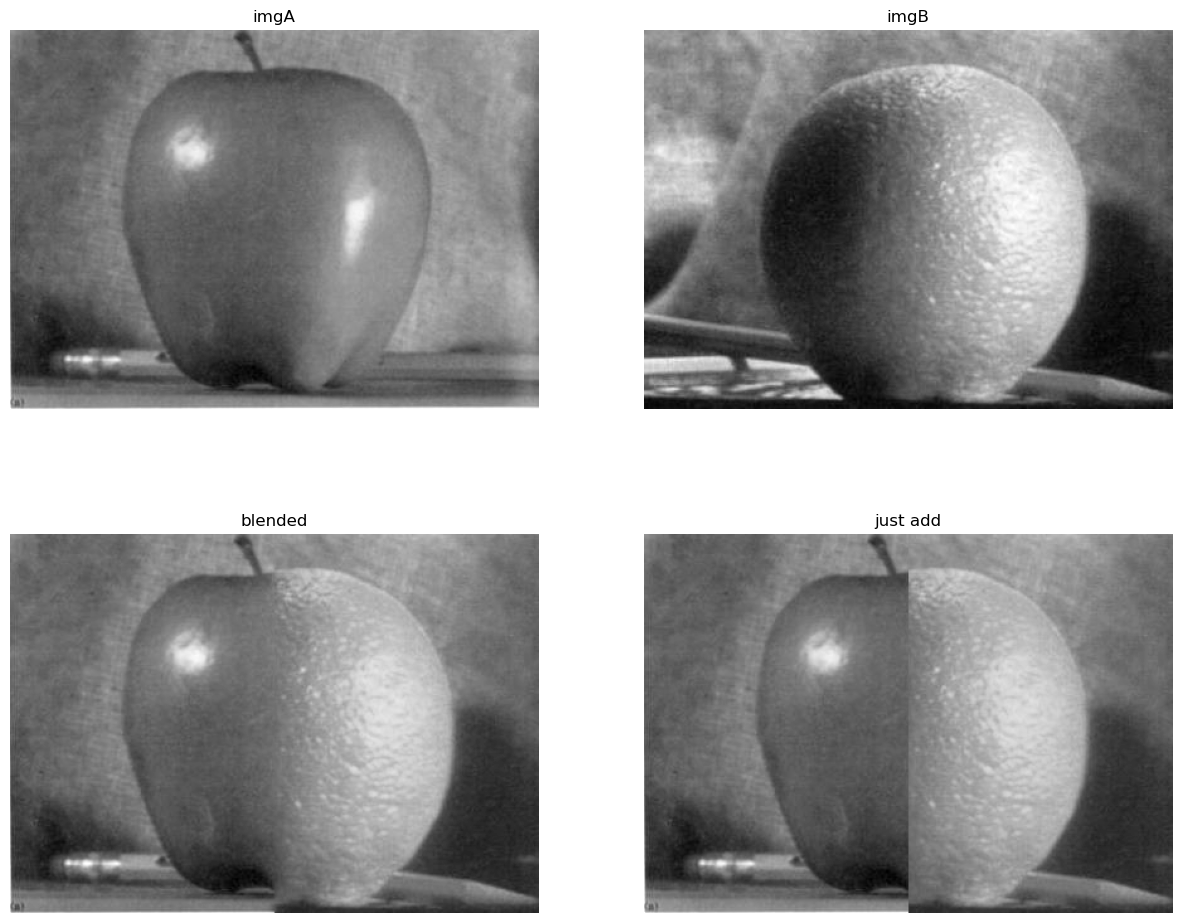

In [32]:
# Specify your imgA and imgB here
imgA, imgB = img1, img2

# Compute LA and LB
my_gpA = make_gaussian_pyramids(imgA, max_level=6)
my_lpA = make_laplacian_pyramids(my_gpA)
my_gpB = make_gaussian_pyramids(imgB, max_level=6)
my_lpB = make_laplacian_pyramids(my_gpB)

# Create mask, simply zeroing out the right-half of the image
maskA = np.ones_like(imgA)
maskA[:, imgA.shape[1]//2:] = 0.
my_img_add = maskA * imgA + (1 - maskA) * imgB
gpMask = make_gaussian_pyramids(maskA, max_level=6)

# Compute blended laplacian pyramid lpS and construct the image back
my_lpS = blend_laplacians(gpMask, my_lpA, my_lpB)
my_img_blended = laplacian_collapse(my_lpS)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes[0,0].imshow(imgA, "gray")
axes[0,0].set_title('imgA')
axes[0,0].set_axis_off()
axes[0,1].imshow(imgB, "gray")
axes[0,1].set_title('imgB')
axes[0,1].set_axis_off()

axes[1,0].imshow(my_img_blended, "gray")
axes[1,0].set_title('blended')
axes[1,0].set_axis_off()
axes[1,1].imshow(my_img_add, "gray")
axes[1,1].set_title('just add')
axes[1,1].set_axis_off()
plt.show()

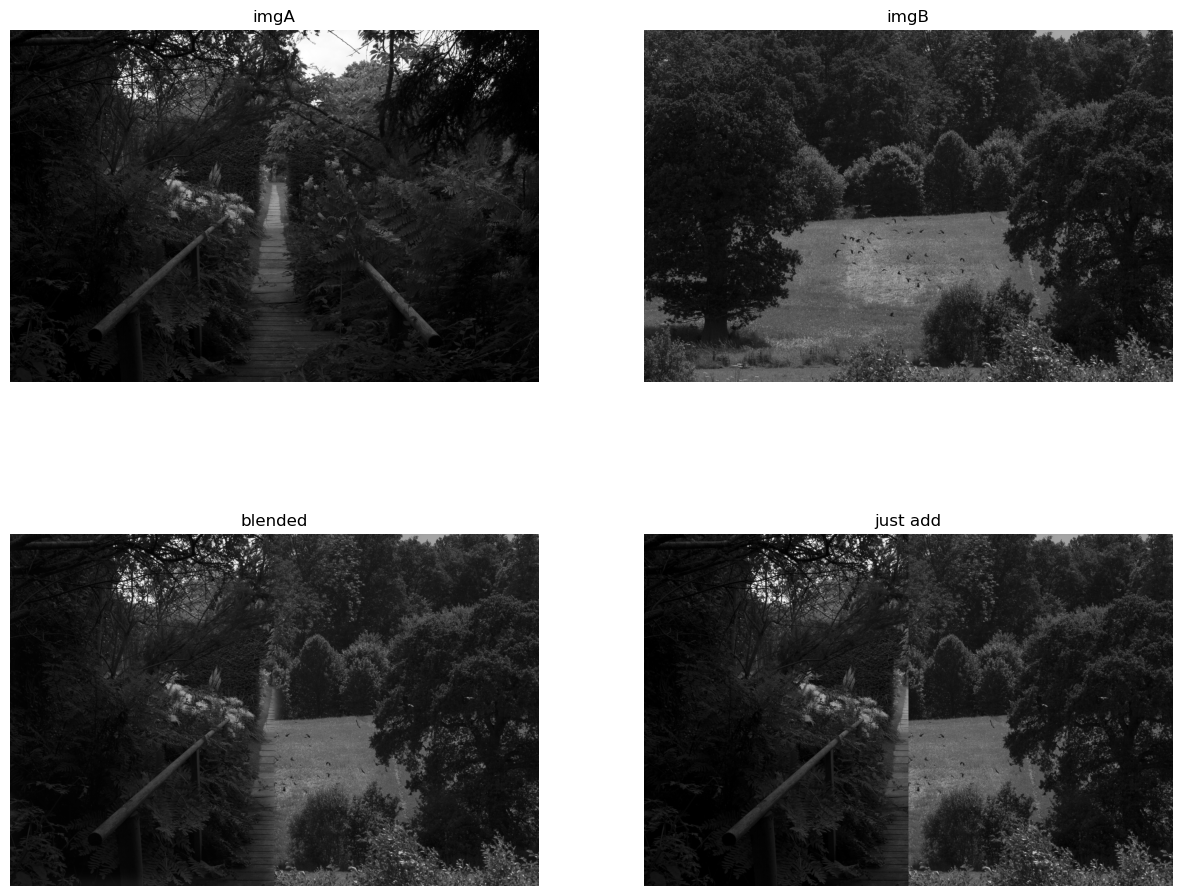

In [34]:
# Specify your imgA and imgB here
imgA, imgB = img3, img4

# Compute LA and LB
my_gpA = make_gaussian_pyramids(imgA, max_level=6)
my_lpA = make_laplacian_pyramids(my_gpA)
my_gpB = make_gaussian_pyramids(imgB, max_level=6)
my_lpB = make_laplacian_pyramids(my_gpB)

# Create mask, simply zeroing out the right-half of the image
maskA = np.ones_like(imgA)
maskA[:, imgA.shape[1]//2:] = 0.
my_img_add = maskA * imgA + (1 - maskA) * imgB
gpMask = make_gaussian_pyramids(maskA, max_level=6)

# Compute blended laplacian pyramid lpS and construct the image back
my_lpS = blend_laplacians(gpMask, my_lpA, my_lpB)
my_img_blended = laplacian_collapse(my_lpS)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes[0,0].imshow(imgA, "gray")
axes[0,0].set_title('imgA')
axes[0,0].set_axis_off()
axes[0,1].imshow(imgB, "gray")
axes[0,1].set_title('imgB')
axes[0,1].set_axis_off()

axes[1,0].imshow(my_img_blended, "gray")
axes[1,0].set_title('blended')
axes[1,0].set_axis_off()
axes[1,1].imshow(my_img_add, "gray")
axes[1,1].set_title('just add')
axes[1,1].set_axis_off()
plt.show()